In [2]:
# import the needed packages
import pandas as pd
import stlearn as st
import scanpy as sc
import scanpy.external as sce
# import squidpy as sq
import matplotlib.pyplot as plt
import os
import sys
import subprocess
import numpy as np
import anndata as ad
from anndata import AnnData
import matplotlib as mpl
import seaborn as sns; sns.set(color_codes=True)
import monkeybread as mb

import cupy as cp
import time
import rapids_singlecell as rsc

import scimap as sm

# make sure that we are in the right directory
print(os.getcwd())

# set the filenames we are looking at
filenames = ["S17_7722_E4","S1614455_C21","S17_16197_A1","S18_13562_A1","S18_5464_A1","S18_13562_B1","S17_10147B7_S2"]
pop_samples = ['Haitian','Haitian','African American','African American','Haitian','African American','Haitian']
malGenes = ["DAPI","CyclinD1","CD34","G6PD","CD15","Cytokeratin6","CD8","CD20","ER","Keratin17","CPT1A"]

/mnt/plummergrp/QuPath_0.4.4/BrCa


In [ ]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [ ]:
for i in range(len(filenames)):

    df = pd.read_csv("./"+filenames[i]+".txt", sep='\t', lineterminator='\n')

    # create the cell matrix
    df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
    # leave only protein names
    df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
    # drop DAP1 because it is inconsequential to the downstream analysis
    # df_mat = df_mat.drop(columns=["DAPI"])
    # drop genes that have bad stitchings
    # df_mat = df_mat.drop(columns=['CD11c', 'CD34', 'CyclinD1', 'G6PD', 'CD15'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_mat.index = df_mat.index + 1
    # save it as a csv
    df_mat.to_csv("./"+filenames[i]+"_matrix.csv", index=True)

    # create the metadata file
    df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
    # calculate the cytoplasm as the cell minus the nucleus
    df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_meta.index = df_meta.index + 1
    # save it as a csv
    df_meta.to_csv("./"+filenames[i]+"_metadata.csv", index=True)

In [ ]:
# load the data into Anndata
adatas = []

for i in range(len(filenames)):
    count_matrix = pd.read_csv('./'+filenames[i]+'_matrix.csv', index_col=0)
    spatial = pd.read_csv('./'+filenames[i]+'_metadata.csv', index_col=0)
    spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

    adatas.append(st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white"))
    # adatas[i].obs['ImageID'] = filenames[i]
    # st.pl.QC_plot(adatas[i], spot_size=(1,10))
    print(adatas[i])

In [ ]:
# remove stardist artifacts using DAPI expression level
n_bins = 50
for i in range(len(filenames)):
    adatas[i] = adatas[i][adatas[i][:, 'DAPI'].X > 10, :]
    # find out histogram of DAPI expression
    # plt.hist(adatas[i].X[:,0], n_bins)
    # plt.show()
    # st.pl.QC_plot(adatas[i], spot_size=(1,10))
    
# remove the problematic genes for clustering + DAPI
genes = pd.Index.tolist(adatas[i].var_names)
for gene in malGenes:  
    genes.remove(gene)

for i in range(len(filenames)):
    adatas[i] = adatas[i][:,genes]
    # print(adatas[i].var_names)
    print(adatas[i])

# find all the gene names
genes = pd.Index.tolist(adatas[0].var_names)
malGenes = ["CyclinD1","CD34","G6PD","CD15","Cytokeratin6","CD8","CD20","ER","Keratin17","CPT1A"]
# produce gene expression plots
for i in range(len(filenames)):
    adata_temp = adatas[i].copy()
    st.pp.scale(adata_temp)
    for gene in malGenes:
        st.pl.gene_plot(adata_temp, gene_symbols=gene)
        plt.show()

In [ ]:
genes = pd.Index.tolist(adatas[0].var_names)

In [ ]:
# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [ ]:
# normalize the datasets individually
for i in range(len(filenames)):
    st.pp.filter_genes(adatas[i],min_cells=1)
    clr_normalize_each_cell(adatas[i])

# combine the datasets
adata = adatas[0]
adata = adata.concatenate(adatas[1::], batch_key="ImageID", batch_categories=filenames, uns_merge="first")
print(adata)
# pd.DataFrame(adata.X).to_csv("./session_matrix.csv", header=adatas[i].var_names)

# save the anndata!
adata.write_h5ad('./session_file.h5ad')

new way of running harmonypy using a python script instead
first run the following commands in terminal:
export NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
export OMP_NUM_THREADS=1

now run the python script
python RunHarmony.py

In [ ]:
# load anndata
adata = ad.read_h5ad('./session_file_harmony.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
# rsc.utils.anndata_to_GPU(adata)

# calculate nneighbours
rsc.pp.neighbors(adata, n_neighbors=30, n_pcs=50, use_rep='X_pca')

# run umap
rsc.tl.umap(adata)

# run tsne
rsc.tl.tsne(adata, n_pcs = 50,perplexity=10,early_exaggeration=12, learning_rate=200)

# run louvain/leiden clustering
rsc.tl.louvain(adata, resolution=0.5)
rsc.tl.leiden(adata,resolution=0.5)

# umap/tsne plot
sc.pl.umap(adata, color=['louvain', 'leiden', 'ImageID'], size=1)
sc.pl.tsne(adata, color=['louvain', 'leiden', 'ImageID'],legend_loc = 'on data')
adata

# save it because it takes a long time
adata.write_h5ad('./session_file_leiden.h5ad')

In [ ]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='leiden', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='leiden', swap_axes=True, vmin=-5, vmax=5)

In [ ]:
# map the clusters onto the tissues
# load anndata
# adata = ad.read_h5ad('../rapids-single-cell-examples-master/notebooks/session_file_harmony.h5ad')
adata_samples = []
for i in range(len(filenames)):
    adata_samples.append(adata[adata.obs['ImageID'] == filenames[i]])
    # adata_samples.append(adata[adata.obs['batch'] == "sample"+str(i)])  
    # adata_samples[i].uns['spatial'] = adatas[i].uns['spatial']
    st.pl.cluster_plot(adata_samples[i],use_label="leiden", show_cluster_labels=True, size=1, figsize=(8, 8))
    plt.show()

In [ ]:
# proportion of clusters in each sample
plt_data_samples = []
for i in range(len(filenames)):
    plt_data_sample={}
    for v in adata_samples[i].obs['leiden'].unique():
        plt_data_sample[v]=adata_samples[i][adata_samples[i].obs['leiden']==v].shape[0]/adata_samples[i].shape[0]*100
    plt_data_samples.append(plt_data_sample)

df = pd.DataFrame.from_dict(plt_data_samples[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_samples[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(7,7))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Clusters (Leiden)")
plt.show()

In [ ]:
# niche analysis of the combined data 
niche_subtypes = []
other_cell_types = ['8','3']

for cell, ct in zip(adata.obs.index, adata.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes.append('malignant/other')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = niche_subtypes
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))

adata.obsm['X_spatial'] = adata.obsm['spatial']
immune_mask = ~adata.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask
)

# Subset cells
adata_neighbors_sub = sc.pp.subsample(
    adata_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

print(adata)

In [ ]:
# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors.obs['niche'])))
}

adata_niches = []
for i in range(len(filenames)):
    adata_niches.append(adata[adata.obs['batch'] == str(i)])

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        adata_niches[i],
        "spatial",
        color = 'niche',
        palette=niche_to_color,
        size=1,
        ax=ax,
        show=False,
    )
    plt.show()

In [ ]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale the data
adata_niches_scaled = []
for i in range(len(filenames)):
    adata_niches_scaled.append(adata_niches[i].copy())
    st.pp.scale(adata_niches_scaled[i], zero_center=True)

    # create gene expression heatmap
    sc.pl.heatmap(adata_niches_scaled[i], genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=5)

In [ ]:
# proportion of niches in each sample
plt_data_niches = []
for i in range(len(filenames)):
    plt_data_niche = {}
    for v in adata_niches[i].obs['niche'].unique():
        plt_data_niche[v]=adata_niches[i][adata_niches[i].obs['niche']==v].shape[0]/adata_niches[i].shape[0]*100
    plt_data_niches.append(plt_data_niche)


df = pd.DataFrame.from_dict(plt_data_niches[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_niches[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,8))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

In [ ]:
# load in the astir generated cell types and plot onto the tissues
celltypes = pd.read_csv('./session_cell-types.csv', index_col=0)['cell_type']
adata.obs['celltypes'] = celltypes.to_numpy()
adata.obs['celltypes'] = adata.obs['celltypes'].astype('category')

astir_adatas = []
for i in range(len(filenames)):
    astir_adatas.append(adata[adata.obs['batch'] == str(i)])
    astir_adatas[i].uns['spatial'] = adatas[i].uns['spatial']

set_celltypes = {'Normal Epithelial cells',
                 'Tumor cells', 
                 'Proliferating Tumor cells',
                 'Myoepithelial cells',
                 'Granulocytes',
                 'Telocytes',
                 'Endothelial cells',
                 'M2 Macrophages',
                 'M1 Macrophages',
                 'Fibroblasts',
                 'B cells',
                 'Cytotoxic T cells',
                 'Tregs',
                 'Helper T cells',
                 'Unknown',
                 'Other'}

# Map each niche to a color so that plots are consistent
type_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set_celltypes))
}

for i in range(len(filenames)):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        astir_adatas[i],
        "spatial",
        color = 'celltypes',
        palette=type_to_color,
        size=2,
        ax=ax,
        show=False
    )
    plt.show()

In [ ]:
# for each marker clip value to mean of top 20 values
def mediantop20(subAD):
    outAD = subAD.copy()
    for ix,x in enumerate(outAD.var_names):
        aX = subAD[:,x].X.flatten()
        top20 = np.sort(aX)[-20:]
        outAD.X[:,ix] = np.clip(subAD[:,x].X.flatten(),0,np.median(top20))
    return outAD

# remove expression outliers from the data
def removeOutliers(ad):

    # separate each sample
    s = {}
    for sID in ad.obs.ImageID.sort_values().unique():
        print(sID)
        s[sID] = ad[ad.obs['ImageID']==sID]
        print(s[sID].X.max(axis=0))
        s[sID] = mediantop20(s[sID])
        print(s[sID].X.max(axis=0))
    outAD = sc.concat(s.values())
    return outAD

In [ ]:
# rescale and run cell phenotyping
adata = ad.read_h5ad('./session_file_leiden.h5ad')

newAD = removeOutliers(adata)
newAD = sm.pp.rescale(newAD,imageid='ImageID', method='by_image')

# phenotype the cells
phenoDF = pd.read_csv('../SciMap/phenotype_workflow.csv')
phenoDF.drop(inplace=True, columns=malGenes)
sm.tl.phenotype_cells(newAD,phenoDF,label='phenotype')
newAD.obs.groupby('ImageID').phenotype.value_counts()
newAD.write_h5ad('./session_file_scimap.h5ad')

In [3]:
# map the phenotypes onto the tissues
adata = ad.read_h5ad('./session_file_leiden.h5ad')
newAD = ad.read_h5ad('./session_file_scimap.h5ad')

adata.obs['phenotype'] = newAD.obs['phenotype'].astype('category')
adata.obs['phenotype'] = adata.obs['phenotype'].str.replace('likely-', '').astype('category')
adatas_sm = []
for i in range(len(filenames)):
    adatas_sm.append(adata[adata.obs['batch'] == filenames[i]])
    # print(adatas_sm[i])
    # adata_samples.append(adata[adata.obs['batch'] == "sample"+str(i)])  
    # st.pl.cluster_plot(adatas_sm[i],use_label="phenotype", show_cluster_labels=False, size=0.5, figsize=(8, 8))
    # plt.show()

In [4]:
# generate random squares of the images 
import random
radius_box = 400 # radius box sizes
num_sq = 20 # how many random squares we generate for each sample
min_cells = 100 # lowest number of cells allowed

# load in the workflow
phenoDF = pd.read_csv('../SciMap/phenotype_workflow.csv')
phenoDF.drop(inplace=True, columns=malGenes[1::])

# define a function that flattens list which is useful later on
def flatten(l):
    return [item for sublist in l for item in sublist]

# initialize the lists/dfs used to store the scores and the mistakes
df_mistakes = pd.DataFrame(0, index=adatas_sm[0].obs['phenotype'].unique().tolist(), columns=['num_mistakes', 'num_total', '%_wrong'])
df_gene_mistakes = pd.DataFrame(0, index=adatas_sm[0].obs['phenotype'].unique().tolist(), columns=pd.Index.tolist(adatas_sm[0].var_names))

total_cells = 0
for i in range(len(filenames)):
    # scale the data
    temp_uncut = adatas_sm[i].copy()
    st.pp.scale(temp_uncut, zero_center=True)

    # calculate the standard deviations we are going to use
    groups_tot = temp_uncut.obs['phenotype'].unique().tolist()
    genes_tot = pd.Index.tolist(temp_uncut.var_names)
    df_tot = pd.DataFrame(columns=genes_tot, index=groups_tot)
    temp_pheno = temp_uncut.obs['phenotype']
    X_temp_uncut = np.array(temp_uncut.X)


    # for each element in the table, calculate the mean expression
    for group in groups_tot:
        phenotype_cells = X_temp_uncut[temp_pheno == group, :]
        mean_expression = phenotype_cells.mean(axis=0)
        df_tot.loc[group] = mean_expression
    mystd = df_tot.std()
    
    j = 0
    while j < num_sq:
        # draw a box for where the centroids can be such that it wont touch the edge
        x_min = min(temp_uncut.obs["imagecol"])+radius_box
        x_max = max(temp_uncut.obs["imagecol"])-radius_box
        y_min = min(temp_uncut.obs["imagerow"])+radius_box
        y_max = max(temp_uncut.obs["imagerow"])-radius_box

        # randomly generate a centroid
        x_cent = random.random()*(x_max-x_min)+x_min
        y_cent = random.random()*(y_max-y_min)+y_min
        # print(str(x_cent) + ", " + str(y_cent))

        x_min_cut = x_cent-radius_box # want x to be bigger than this value
        x_max_cut = x_cent+radius_box # want x to be smaller than this value
        y_min_cut = y_cent-radius_box # want y to be bigger than this value
        y_max_cut = y_cent+radius_box # want y to be smaller than this value

        # create the randomly drawn box
        temp_scaled = temp_uncut[(temp_uncut.obs['imagecol']>x_min_cut) 
                            & (temp_uncut.obs['imagecol']<x_max_cut)
                            & (temp_uncut.obs['imagerow']>y_min_cut)
                            & (temp_uncut.obs['imagerow']<y_max_cut)]

        # print(temp)
        if(len(temp_scaled)>min_cells):
            total_cells = total_cells + len(temp_scaled)
            genes = pd.Index.tolist(temp_scaled.var_names)

            # create cluster plot
            # st.pl.cluster_plot(temp_scaled,use_label="phenotype", show_cluster_labels=False, size=12, figsize=(8, 8), title=filenames[i])
            
            # create gene expression dotplot
            # sc.pl.dotplot(temp_scaled, genes, groupby='phenotype', dendrogram=False, title=filenames[i])

            # create a data frame that is cell types x genes
            groups = temp_scaled.obs['phenotype'].unique().tolist()
            genes = pd.Index.tolist(temp_scaled.var_names)
            df = df_tot.loc[groups]

            # create a workflow table that is correspondant with the subsample
            absentCells = list((set(groups) ^ set(adata.obs['phenotype'].unique().tolist())))
            temp_phenoDF = phenoDF[~phenoDF['Unnamed: 1'].isin(absentCells)].copy()
            temp_phenoDF.drop(inplace=True, columns = 'Unnamed: 0')
            temp_phenoDF.set_index('Unnamed: 1', inplace=True)
            
            # compare the workflow with the mean expression
            # correctness:
            # if the workflow indicates pos, and the mean expression is >1 std
            # if the workflow indicates NaN, and the mean expression is >-1 std and <1 std
            # if the workflow indicates neg, and the mean expression is <-1 std

            for group in groups:
                for gene in genes:
                    df_mistakes.at[group, 'num_total'] = df_mistakes.at[group, 'num_total'] + 1
                    if (type(temp_phenoDF.at[group, gene]) == np.float64 or type(temp_phenoDF.at[group, gene]) == float) and pd.isna(temp_phenoDF.at[group, gene]):
                        if abs(df.at[group, gene]) > mystd[gene]:
                            df_mistakes.at[group, 'num_mistakes'] = df_mistakes.at[group, 'num_mistakes'] + 1
                            df_gene_mistakes.at[group, gene] = df_gene_mistakes.at[group, gene] + 1
                    elif isinstance(temp_phenoDF.at[group, gene], str) and 'pos' in temp_phenoDF.at[group, gene]:
                        if df.at[group, gene] <= mystd[gene]:
                            df_mistakes.at[group, 'num_mistakes'] = df_mistakes.at[group, 'num_mistakes'] + 1
                            df_gene_mistakes.at[group, gene] = df_gene_mistakes.at[group, gene] + 1
                    elif isinstance(temp_phenoDF.at[group, gene], str) and 'neg' in temp_phenoDF.at[group, gene]:
                        if df.at[group, gene] >= -mystd[gene]:
                            df_mistakes.at[group, 'num_mistakes'] = df_mistakes.at[group, 'num_mistakes'] + 1
                            df_gene_mistakes.at[group, gene] = df_gene_mistakes.at[group, gene] + 1
            j = j+1

# find out which cell types are most falsely identified
for group in df_mistakes.index.tolist():
    df_mistakes.at[group, '%_wrong'] = (df_mistakes.at[group, 'num_mistakes']*100)/df_mistakes.at[group, 'num_total']
df_mistakes.sort_values(inplace=True, by='%_wrong', ascending=False)
print(df_mistakes)

# print total score
print(((sum(df_mistakes['num_total'])-sum(df_mistakes['num_mistakes']))/sum(df_mistakes['num_total']))*100)

Scale step is finished in adata.X
Scale step is finished in adata.X
Scale step is finished in adata.X
Scale step is finished in adata.X
Scale step is finished in adata.X
Scale step is finished in adata.X
Scale step is finished in adata.X
                           num_mistakes  num_total    %_wrong
Non-immune cells                   2658       6435  41.305361
Myeloid Lineage                    2322       6655  34.891059
Myoepithelial cells                 240        715  33.566434
Normal epithelial cells            1330       4015  33.125778
Proliferating tumor cells          1807       5775  31.290043
Endothelial cells                  1707       6545  26.080978
Granulocytes                       1647       6435  25.594406
Tumor cells                        1694       7370  22.985075
M1 Macrophages                     1396       7150  19.524476
Helper T cells                     1023       6270  16.315789
Cytotoxic T cells                   753       4895  15.383044
M2 Macrophages    

In [ ]:
# find out the % of mistake for each gene by cell type
df_gene_mistakes_percent = pd.DataFrame(0, index=adatas_sm[0].obs['phenotype'].unique().tolist(), columns=pd.Index.tolist(adatas_sm[0].var_names))
for group in df_gene_mistakes.index.tolist():
    for gene in df_gene_mistakes.columns.tolist():
        df_gene_mistakes_percent.at[group, gene] = (df_gene_mistakes.at[group, gene]*100)/(df_mistakes.at[group, 'num_total']/len(df_gene_mistakes.columns.tolist()))

df_gene_mistakes_percent.style.background_gradient(cmap ='viridis', axis=None)\
        .set_properties(**{'font-size': '20px'}) 

In [ ]:
# find out which genes have the most mistakes
df_gene_summed_mistakes = pd.DataFrame(0, index=df_gene_mistakes.columns.tolist(), columns=['%_mistakes'])
for gene in df_gene_mistakes.columns.tolist():
    df_gene_summed_mistakes.at[gene, '%_mistakes'] = (sum(df_gene_mistakes[gene])/(sum(df_mistakes['num_total'])/len(df_gene_mistakes.columns.tolist())))*100
df_gene_summed_mistakes.sort_values(inplace=True, by='%_mistakes', ascending=False)
print(df_gene_summed_mistakes)

In [5]:
# phenotype the cells manually to test the logic
df_cell_genes = pd.DataFrame(0, index=list(range(0, len(temp_scaled.obs_names))), columns=temp_scaled.var_names)
# create an expression matrix in np array so it runs exponentially faster
exp_mat = np.array(temp_scaled.X)

# turn the matrix into a ternary:
# 1: the expression is >1 std --> upregulated
# 0: the expression is within 1 std 
# -1: the expression is <-1 std --> downregulated

for i in range(len(df_cell_genes)):
   j = 0
   for gene in temp_scaled.var_names:
      if exp_mat[i, j] > mystd[gene]:
         df_cell_genes.at[i, gene] = 1
      elif exp_mat[i, j]< -mystd[gene]:
         df_cell_genes.at[i, gene] = -1
      j = j+1


In [6]:
# load in the workflow
phenoDF = pd.read_csv('../SciMap/phenotype_workflow.csv')
phenoDF.drop(inplace=True, columns=malGenes[1::])
phenoDF.drop(inplace=True, columns = 'Unnamed: 0')
phenoDF.set_index('Unnamed: 1', inplace=True)

# generate anypos cell types + genes
df_anypos = pd.DataFrame(columns=['phenotypes', 'genes'])

# iterate over rows in 'df_pheno' and filter based on the condition
for index, row in phenoDF.iterrows():
    if 'anypos' in row.values:
        cell_type = index
        genes_with_anypos = row[row == 'anypos'].index.tolist()

        # append the cell type and gene list to the new DataFrame
        df_anypos = pd.concat([df_anypos, pd.DataFrame({'phenotypes': cell_type, 'genes': genes_with_anypos})], ignore_index=True)

# reset the index using the genes for ease of access
df_anypos.set_index('genes', inplace=True)
# print(df_anypos)

In [24]:
# score the cell types using the difference between the standard deviation and the expression level

cell_phenotypes = []
factor = 3

for i in range(len(df_cell_genes)):
    single_use_phenotypes = pd.DataFrame(0, index=groups_tot, columns=['score'])
    for group in groups_tot:
        score = 0
        j = 0
        for gene in genes_tot:
            if (type(phenoDF.at[group, gene]) == np.float64 or type(phenoDF.at[group, gene]) == float) and pd.isna(phenoDF.at[group, gene]):
                diff = abs(exp_mat[i, j]) - abs(mystd[gene])
                if abs(exp_mat[i, j]) <= mystd[gene]:
                    score = score + (diff**factor)
                else:
                    score = score - diff
            elif isinstance(phenoDF.at[group, gene], str) and 'pos' in phenoDF.at[group, gene]:
                diff = abs(exp_mat[i, j] - mystd[gene])
                if exp_mat[i, j] > mystd[gene]:
                    score = score + (diff**factor)
                else:
                    score = score - (diff**(factor/3))
            elif isinstance(phenoDF.at[group, gene], str) and 'neg' in phenoDF.at[group, gene]:
                diff = abs(exp_mat[i, j]) + (mystd[gene])
                if exp_mat[i, j] < -mystd[gene]:
                    score = score + (diff**factor)
                else:
                    score = score - (diff**(factor/3))
            j = j + 1
        single_use_phenotypes.at[group, 'score'] = score
    cell_phenotypes.append(str(single_use_phenotypes.sort_values(ascending=False, by='score').index[0]))
print(cell_phenotypes)

['M2 Macrophages', 'Normal epithelial cells', 'M2 Macrophages', 'Tregs', 'Normal epithelial cells', 'Normal epithelial cells', 'Fibroblasts', 'M2 Macrophages', 'Proliferating tumor cells', 'Normal epithelial cells', 'M2 Macrophages', 'Normal epithelial cells', 'Tregs', 'Normal epithelial cells', 'Normal epithelial cells', 'Normal epithelial cells', 'M1 Macrophages', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Fibroblasts', 'Normal epithelial cells', 'Normal epithelial cells', 'Proliferating tumor cells', 'Proliferating tumor cells', 'Normal epithelial cells', 'Tregs', 'Normal epithelial cells', 'Normal epithelial cells', 'Proliferating tumor cells', 'Normal epithelial cells', 'Normal epithelial cells', 'Tregs', 'Normal epithelial cells', 'Proliferating tumor cells', 'M2 Macrophages', 'Normal epithelial cells', 'Normal epithelial cells', 'M2 Macrophages', 'N

['M2 Macrophages' 'Normal epithelial cells' 'M2 Macrophages' ... 'Tregs'
 'Proliferating tumor cells' 'Proliferating tumor cells']


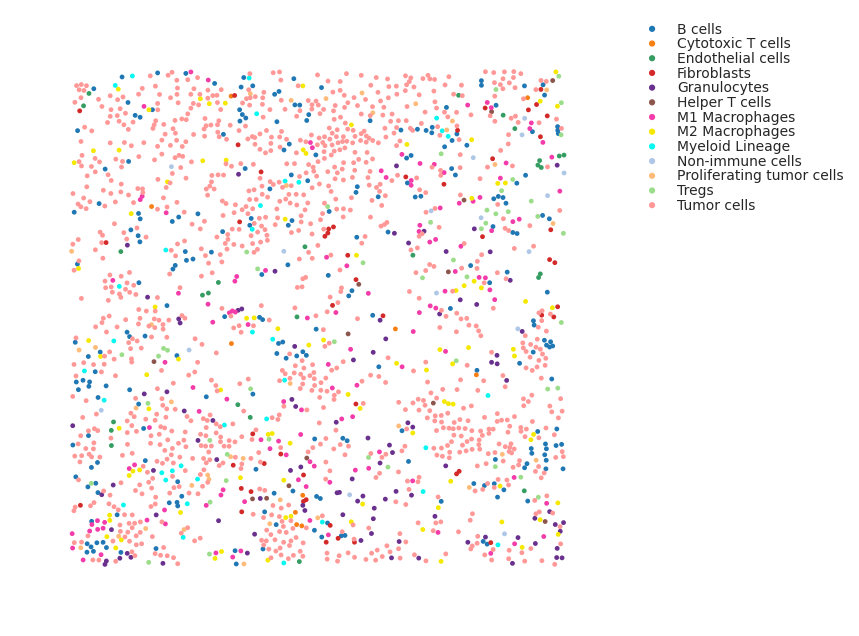

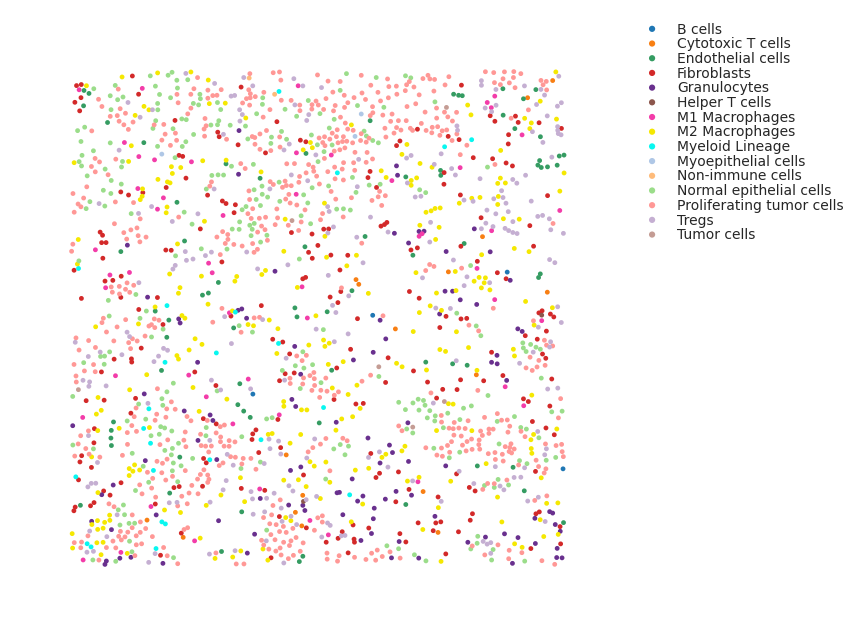

In [39]:
st.pl.cluster_plot(temp_scaled,use_label="phenotype", show_cluster_labels=False, size=12, figsize=(8, 8))
cell_phenotypes = pd.Series(cell_phenotypes)
temp_scaled.obs['custom_pheno'] = cell_phenotypes.to_numpy()
temp_scaled.obs['custom_pheno'] = temp_scaled.obs['custom_pheno'].astype('category')
st.pl.cluster_plot(temp_scaled,use_label="custom_pheno", show_cluster_labels=False, size=12, figsize=(8, 8))

In [48]:
# compare the ARI between the clusters
from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(temp_scaled.obs['phenotype'], temp_scaled.obs['custom_pheno']))
# oof

0.2130071077264392


In [11]:
cell_phenotypes = []
i = 0
# for i in range(len(df_cell_genes)):
    # for gene in df_anypos.index.tolist():
    #    if df_cell_genes.at[i, gene] == 1:
    #        cell_phenotypes.append(df_anypos.at[gene, 'phenotypes'])
single_use_phenotypes = pd.DataFrame(0, index=groups_tot, columns=['score'])
for group in groups_tot:
    correct = 0
    for gene in genes_tot:
        if (type(phenoDF.at[group, gene]) == np.float64 or type(phenoDF.at[group, gene]) == float) and pd.isna(phenoDF.at[group, gene]):
            if df_cell_genes.at[i, gene] == 0:
                correct = correct + 1
            else:
                correct = correct - 1
        elif isinstance(phenoDF.at[group, gene], str) and 'pos' in phenoDF.at[group, gene]:
            if df_cell_genes.at[i, gene] == 1:
                correct = correct + 3
            else:
                correct = correct - 1
        elif isinstance(phenoDF.at[group, gene], str) and 'neg' in phenoDF.at[group, gene]:
            if df_cell_genes.at[i, gene] == -1:
                correct = correct + 3
            else:
                correct = correct - 1
    single_use_phenotypes.at[group, 'score'] = correct
print(single_use_phenotypes.sort_values(ascending=False, by='score'))
            
# print(pd.DataFrame(cell_phenotypes, columns=['phenotypes']).value_counts())
# print(temp_scaled.obs['phenotype'].value_counts())
# print(len(temp_scaled.obs['phenotype']))

                           score
M2 Macrophages                29
M1 Macrophages                27
Normal epithelial cells       23
Myeloid Lineage               21
Non-immune cells              21
Fibroblasts                   21
Proliferating tumor cells     21
Tumor cells                   19
B cells                       19
Granulocytes                  19
Myoepithelial cells           19
Endothelial cells             17
Helper T cells                15
Cytotoxic T cells             15
Tregs                         13


In [ ]:
# proportion of cell types in each sample
plt_data_samples = []
for i in range(len(filenames)):
    plt_data_sample={}
    for v in adatas_sm[i].obs['phenotype'].unique():
        plt_data_sample[v]=adatas_sm[i][adatas_sm[i].obs['phenotype']==v].shape[0]/adatas_sm[i].shape[0]*100
    plt_data_samples.append(plt_data_sample)

df = pd.DataFrame.from_dict(plt_data_samples[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_samples[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(7,7))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Phenotypes")
plt.show()

In [ ]:
# examine the two population groups
groups = list(set(pop_samples))
celltypes = []
for i in range(len(filenames)):
    celltypes.append(adatas_sm[i].obs['phenotype'])

pop_celltypes = []
for group in groups:
    temp = []
    for i in range(len(filenames)):
        if group == pop_samples[i]:
            temp.append(celltypes[i])
    pop_celltypes.append(temp)

for i in range(len(pop_celltypes)):
    pop_celltypes[i] = pd.concat(pop_celltypes[i])

# plot the bar graphs
plt_data_samples = []
for i in range(len(pop_celltypes)):
    plt_data_sample={}
    for v in pop_celltypes[i].unique():
        plt_data_sample[v]=pop_celltypes[i][pop_celltypes[i]==v].shape[0]/pop_celltypes[i].shape[0]*100
    plt_data_samples.append(plt_data_sample)

df = pd.DataFrame.from_dict(plt_data_samples[0],orient='index')  
for i in range(len(pop_celltypes)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_samples[i+1],orient='index')], axis=1)  
df.columns = groups

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(7,7))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Populations")
plt.xticks(rotation=45)
plt.ylabel("% Phenotypes")
plt.show()

In [ ]:
# save anndata
adata.write_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples[i].write_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad')
    adata_niches[i].write_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad')
    adatas[i].write_h5ad('./session_file_adata'+str(i+1)+'.h5ad')

In [ ]:
# load anndata
adata_samples = []
adata_niches = []
adatas = []
adata = ad.read_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples.append(ad.read_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad'))
    adata_niches.append(ad.read_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad'))
    adatas.append(ad.read_h5ad('./session_file_adata'+str(i+1)+'.h5ad'))